<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

We've seen the power of tranfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 totoal classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data(using the power of deep learning)

Our baseline to beat is 50.76% accuracy across 101 classes.

In [4]:
# Check wether we're using GPU.
!nvidia-smi

Fri Feb 28 04:34:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Creating helper functions.
In previous notebooks we've created a sreies of helper functions to do different task, let's download them.

In [5]:
# Get the helper functions.

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-02-28 04:34:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-02-28 04:34:14 (15.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# import a series of helper functions to our notebook.
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data

# 101 Food classes: working with less data.

Our goal is to beat the original Food101 paper with 10% of the training data(using the power of deep learning)

The data we're downloading is from original Food101 dataset but has been process using the image_data_modifictions.

In [7]:
# Download and unzip the data.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


unzip_data("101_food_classes_10_percent.zip")

--2025-02-28 04:34:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   120MB/s    in 16s     

2025-02-28 04:34:34 (94.6 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [8]:
# Setting up directories.
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [9]:
# How many images classes are they ?.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_clas

In [10]:
# Setup data inputs.

import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
                              train_dir,
                              label_mode="categorical",
                              image_size=IMG_SIZE,
                              shuffle=True,
                            )

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
                              test_dir,
                              label_mode="categorical",
                              image_size=IMG_SIZE,
                              shuffle=False,      # Don't shuffle test datast for prediction analysis.
                            )



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:

* Create a ModelCheckpoint callback.
* Create a data augmentation layer to build data augmentation right into the model.
* Build headless (no top layers) Functional backboned-model (we'll create our own layer)
* Compile our model.
* Feature extract for 5 full passes (5 epochs on the train dataset).
                                                             

In [11]:
# Create checkpoint callback..

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback =  tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,   # don't save whole model but only best.
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

In [12]:
# Create data augmentation layer to incorporate it right into the model.
from tensorflow.keras import layers
# from tensorflow.keras.layers import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomWidth(0.2),
  layers.RandomHeight(0.2),
  layers.RandomContrast(0.2),
  # preprocessing.Rescaling(1/255.)   $ REscale inputs of images b/t 0-1. required for models like ResNet50 since for EfficinetNet it already present
], name='data_augmentation')


### Building our Functional model architecture.

In [13]:
# Setup the base model and freeze its layers (This will extract features)

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze it since we're dealing with feature extraction.

# Setup model architecture with traniable top layers.
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(train_data_all_10_percent.element_spec[1].shape[-1], activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# How many trainable paramters are they ?.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
# Compile the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model.
history_10_percent_data = model.fit(
    train_data_all_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 167ms/step - accuracy: 0.1549 - loss: 3.9720 - val_accuracy: 0.4383 - val_loss: 2.5663
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.4656 - loss: 2.4020 - val_accuracy: 0.4921 - val_loss: 2.1278
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.5298 - loss: 1.9671 - val_accuracy: 0.5199 - val_loss: 1.9309
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.5784 - loss: 1.7260 - val_accuracy: 0.5342 - val_loss: 1.8310
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.6200 - loss: 1.5625 - val_accuracy: 0.5358 - val_loss: 1.8023


In [16]:
# Evaluate the model.
model.evaluate(test_data_all_10_percent)

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.5533 - loss: 1.7232


[1.5968315601348877, 0.5829703211784363]

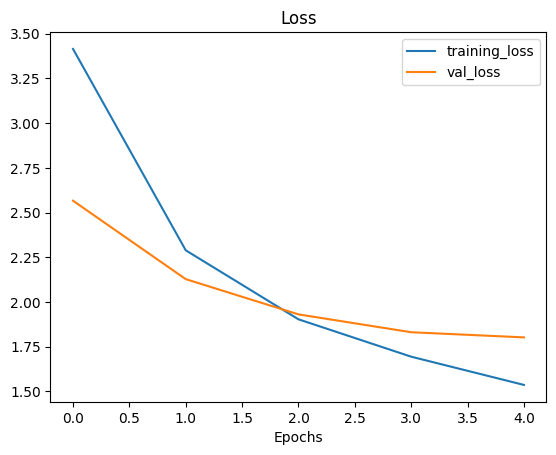

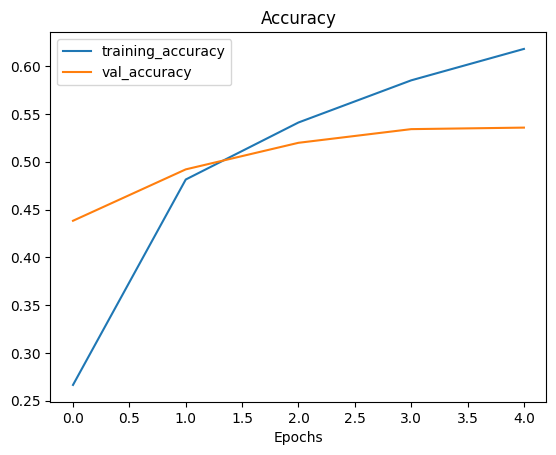

In [17]:
# plot loss curves.
plot_loss_curves(history_10_percent_data)

The two curves should be the same. But from the curves it shows that our model is **Overfitting** hence not being able to **Generalize** (performing too well on training data but not well on test data)

# Fine-tuning

In [18]:
# Unfreeze all of the layers in the base model.
base_model.trainable = True

# Refreeze.
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [19]:
# Recompile the model and lower learning rate.
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [20]:
# Which layers in the model are trianable.
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [21]:
# Check which layers are trainable.
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [22]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs
total_epochs

10

In [23]:
# Fit the model.
history_10_percent_data_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs=total_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data_all_10_percent,
    validation_steps=int(0.15 * len(test_data_all_10_percent)),
    initial_epoch=history_10_percent_data.epoch[-1],
    callbacks=[checkpoint_callback]
)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.6214 - loss: 1.5609 - val_accuracy: 0.5564 - val_loss: 1.7069
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.6708 - loss: 1.3318 - val_accuracy: 0.5667 - val_loss: 1.6618
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.6880 - loss: 1.2618 - val_accuracy: 0.5749 - val_loss: 1.6197
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.7084 - loss: 1.1720 - val_accuracy: 0.5744 - val_loss: 1.6094
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.7204 - loss: 1.1168 - val_accuracy: 0.5837 - val_loss: 1.5922
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.7365 - loss: 1.0656 - val_accuracy: 0.5813 - val_loss: 1.5885


In [24]:
# evaluate the model.
model.evaluate(test_data_all_10_percent)

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.5962 - loss: 1.5165


[1.4134223461151123, 0.6197623610496521]

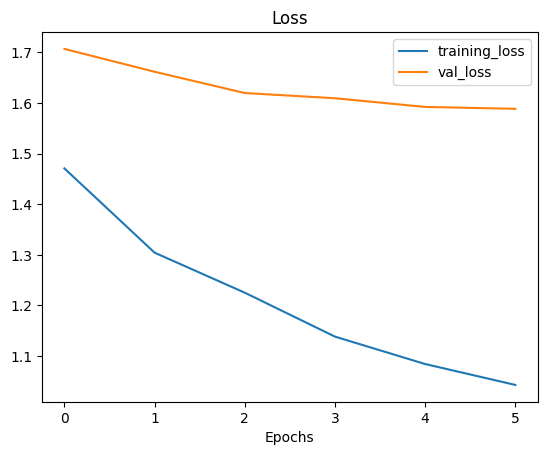

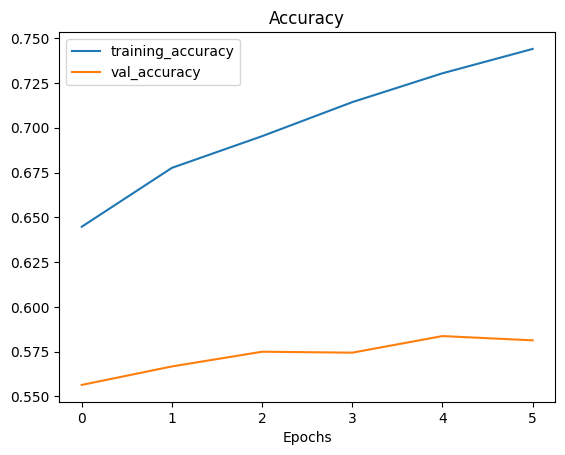

In [25]:
# plot loss curves.
plot_loss_curves(history_10_percent_data_fine_tune)

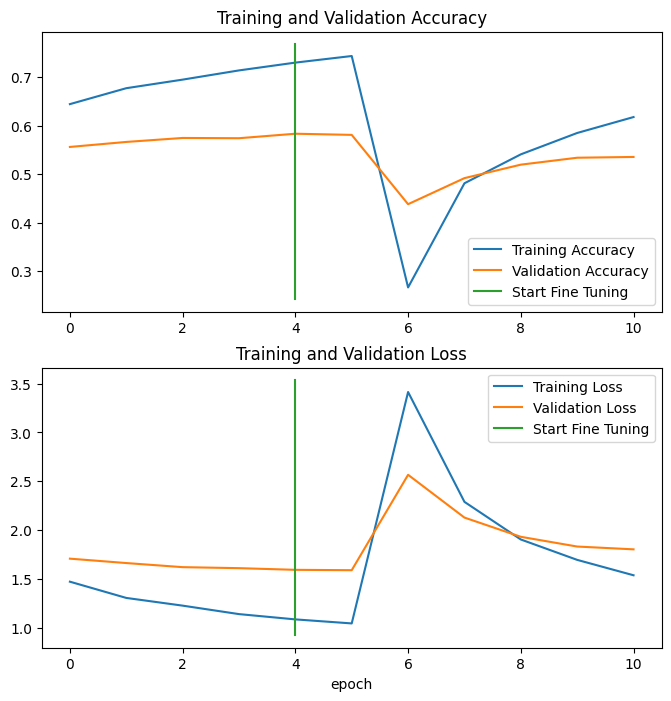

In [26]:
# Compare the histories of feature extraction model with fine-tuning model.
compare_historys(
    original_history=history_10_percent_data_fine_tune,
    new_history=history_10_percent_data,
    initial_epochs=5
    )

## Saving and Loading our Model.

To use our model in an external application, we'll need to save it and export it somewhere.

In [27]:
# Save our fine-tuning model.
model.save("drive/MyDrive/101_food_classes_10_percent_data_model.keras")

In [28]:
# Load and evaluate save model.
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_data_model.keras")

In [29]:
loaded_model

<Functional name=functional_1, built=True>

In [30]:
# Evaluate loaded model and compare performance to pre-saved model.
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 74ms/step - accuracy: 0.5962 - loss: 1.5165


[1.4134223461151123, 0.6197623610496521]

## Evaluating the performance of the big dog model across all different classes.

Let's make some predictions, visualize them and then later find out which predictions where the 'most' wrong.

In [31]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_all_data.zip

unzip_data("101_food_classes_all_data.zip")

--2025-02-28 04:48:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5009098716 (4.7G) [application/zip]
Saving to: ‘101_food_classes_all_data.zip’

101_food_classes_al 100%[===================>]   4.67G   170MB/s    in 41s     

2025-02-28 04:49:05 (116 MB/s) - ‘101_food_classes_all_data.zip’ saved [5009098716/5009098716]



In [32]:
# Load the pretrained model.
model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_data_model.keras")
model

<Functional name=functional_1, built=True>

In [33]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data_all_10_percent)
results_downloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 72ms/step - accuracy: 0.5962 - loss: 1.5165


[1.4134223461151123, 0.6197623610496521]

## Making predictions with our trained model

In [34]:
# Make predictions with model.
preds_probs = model.predict(test_data_all_10_percent, verbose=1)
preds_probs

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step


array([[1.6689493e-01, 7.8965380e-04, 1.6203375e-01, ..., 1.3211675e-04,
        9.9194888e-03, 2.5344843e-02],
       [8.2886100e-01, 2.0749908e-06, 5.1872800e-03, ..., 5.0322847e-03,
        6.2748818e-06, 1.3653595e-04],
       [5.3074211e-01, 7.3718932e-03, 1.7965360e-02, ..., 1.0943180e-03,
        8.3402148e-04, 2.8195295e-03],
       ...,
       [1.6841249e-04, 9.8849572e-02, 5.8601859e-06, ..., 1.5265320e-03,
        1.6067327e-03, 2.2610331e-01],
       [5.3616306e-03, 1.5288997e-02, 1.2724731e-02, ..., 1.2527775e-03,
        7.0263457e-04, 1.2122571e-01],
       [2.7961707e-02, 3.7344475e-03, 1.5812397e-02, ..., 3.2920749e-03,
        1.0598142e-03, 5.8675075e-01]], dtype=float32)

In [35]:
# How many predictions are there ?.
len(preds_probs)

25250

In [36]:
len(test_data_all_10_percent)

790

In [37]:
# Let's see what the first 10 predictions look like.
preds_probs[:10]

array([[1.6689493e-01, 7.8965380e-04, 1.6203375e-01, ..., 1.3211675e-04,
        9.9194888e-03, 2.5344843e-02],
       [8.2886100e-01, 2.0749908e-06, 5.1872800e-03, ..., 5.0322847e-03,
        6.2748818e-06, 1.3653595e-04],
       [5.3074211e-01, 7.3718932e-03, 1.7965360e-02, ..., 1.0943180e-03,
        8.3402148e-04, 2.8195295e-03],
       ...,
       [1.0710402e-01, 3.9309154e-05, 4.8033786e-03, ..., 5.4431640e-02,
        1.6444036e-03, 1.4780209e-03],
       [1.4865775e-01, 4.8409461e-04, 3.5525694e-01, ..., 4.9380260e-04,
        1.5226903e-04, 3.2341635e-04],
       [7.0128417e-01, 3.5219136e-06, 2.5393381e-03, ..., 2.2623453e-03,
        4.5020797e-06, 7.7322446e-04]], dtype=float32)

In [38]:
# What does the first prediction probability array look like ?
preds_probs[0], len(preds_probs[0])

(array([1.6689493e-01, 7.8965380e-04, 1.6203375e-01, 5.3772783e-06,
        4.3843662e-05, 2.2495549e-05, 2.9271157e-04, 6.4271844e-05,
        3.3491742e-02, 6.3382398e-04, 8.9407322e-06, 1.9482892e-05,
        2.5484296e-03, 4.6042614e-06, 2.5209503e-02, 3.0811522e-03,
        1.3090030e-04, 2.5553317e-03, 1.1582382e-02, 8.6798071e-05,
        2.1373348e-03, 2.4525728e-04, 1.2918372e-03, 1.5324898e-03,
        1.1843944e-03, 2.5225824e-03, 2.2423295e-03, 2.1071345e-04,
        2.0367187e-02, 4.9063568e-03, 4.0704741e-05, 3.6590947e-03,
        1.0885204e-03, 9.2862982e-05, 7.4178674e-03, 4.0214290e-05,
        6.7850592e-04, 4.5917099e-03, 1.9621413e-02, 5.8180490e-04,
        9.5731538e-04, 3.3390089e-03, 7.3579786e-04, 5.7706555e-05,
        8.4387121e-04, 3.1503435e-04, 6.0214279e-03, 2.0437670e-04,
        3.9262843e-05, 3.5396308e-02, 5.7475740e-04, 3.7034831e-04,
        1.2793721e-01, 3.4176730e-02, 2.3051199e-04, 3.7191018e-02,
        6.3843764e-03, 2.4986679e-03, 1.6932396e

From above the **SoftMax** has given a unique value to each of our classes.

In [39]:
# we get one prediction probablity per class (in our case there's 101 prediction probability per class)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 has for class 0: {preds_probs[0][0]}")
print(f"The class with the highest prediction probability: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 has for class 0: 0.16689492762088776
The class with the highest prediction probability: 0


In [40]:
test_data_all_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [41]:
test_data_all_10_percent.class_names[preds_probs[0].argmax()]

'apple_pie'

In [42]:
# Get the pred classes of each label.
pred_classes = preds_probs.argmax(axis=1)

# how do they look.
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 72,  2,  0])

In [43]:
# how many pred classes do we have ?.
len(pred_classes)

25250

Now we've got a prediction array of all of our model's prediction to evaluate them. Now we need to compare them with the original test dataset labels.

In [44]:
# To get our test labels we need to unravle our test_data BatchDataset.
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We got all to be zero bcause, When we loaded our model we turn **Shuffle** to be **False** in the test_data_all_percent.

In [45]:
# How many y_labels are there ?.

len(y_labels)

25250

## Evaluating our model's predictions.

ONe way to check that our model's prediction array is in the same order as our test labels array is to find the accuracy score.

In [46]:
results_downloaded_model

[1.4134223461151123, 0.6197623610496521]

In [47]:
# Let's try Scikit-learn's accuracy score function and see what it comes up with.
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6197623762376238

In [48]:
# Does this metric come close to our model's evaluate results.
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: Making a confusion matrix.

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data_all_10_percent.class_names,
                      figsize=(150, 150)
                    )

 Changing the x-axis of our confusion matrix so it get to be printed vertically.

In [50]:

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed (plot x-labels veritcally)
  ax.xaxis.set_rotation(90)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data_all_10_percent.class_names,
                      figsize=(150, 150),
                      savefig=True
                    )

AttributeError: 'XAxis' object has no attribute 'set_rotation'

### Let's keep the evaluation train going, tie for a classifcation report.

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g precision, recall, and F1) called classfication_report.

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.18      0.23       250
           1       0.54      0.75      0.63       250
           2       0.62      0.66      0.64       250
           3       0.79      0.58      0.67       250
           4       0.62      0.36      0.45       250
           5       0.48      0.43      0.45       250
           6       0.72      0.79      0.75       250
           7       0.86      0.78      0.82       250
           8       0.24      0.64      0.35       250
           9       0.41      0.66      0.51       250
          10       0.52      0.43      0.47       250
          11       0.73      0.68      0.70       250
          12       0.69      0.64      0.66       250
          13       0.59      0.54      0.57       250
          14       0.59      0.61      0.60       250
          15       0.41      0.40      0.40       250
          16       0.70      0.55      0.62       250
          17       0.46    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes they get difficult to understand.

In [53]:
# Get a dic of the classification report.
classification_report_dic = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dic

{'0': {'precision': 0.3103448275862069,
  'recall': 0.18,
  'f1-score': 0.22784810126582278,
  'support': 250.0},
 '1': {'precision': 0.5433526011560693,
  'recall': 0.752,
  'f1-score': 0.6308724832214765,
  'support': 250.0},
 '2': {'precision': 0.6217228464419475,
  'recall': 0.664,
  'f1-score': 0.6421663442940039,
  'support': 250.0},
 '3': {'precision': 0.7891891891891892,
  'recall': 0.584,
  'f1-score': 0.671264367816092,
  'support': 250.0},
 '4': {'precision': 0.6180555555555556,
  'recall': 0.356,
  'f1-score': 0.4517766497461929,
  'support': 250.0},
 '5': {'precision': 0.4798206278026906,
  'recall': 0.428,
  'f1-score': 0.452431289640592,
  'support': 250.0},
 '6': {'precision': 0.72,
  'recall': 0.792,
  'f1-score': 0.7542857142857143,
  'support': 250.0},
 '7': {'precision': 0.8590308370044053,
  'recall': 0.78,
  'f1-score': 0.8176100628930818,
  'support': 250.0},
 '8': {'precision': 0.24060150375939848,
  'recall': 0.64,
  'f1-score': 0.34972677595628415,
  'support'

Let's plot all of our classes F1-scores...

In [59]:
# Create empty dic.
class_f1_scores = {}

# Loop through classification report dictionary items.
for key, value in classification_report_dic.items():
  if key == 'accuracy':
    break
  else:
    class_f1_scores[test_data_all_10_percent.class_names[int(key)]] = value['f1-score']

class_f1_scores

{'apple_pie': 0.22784810126582278,
 'baby_back_ribs': 0.6308724832214765,
 'baklava': 0.6421663442940039,
 'beef_carpaccio': 0.671264367816092,
 'beef_tartare': 0.4517766497461929,
 'beet_salad': 0.452431289640592,
 'beignets': 0.7542857142857143,
 'bibimbap': 0.8176100628930818,
 'bread_pudding': 0.34972677595628415,
 'breakfast_burrito': 0.5076452599388379,
 'bruschetta': 0.47058823529411764,
 'caesar_salad': 0.7039337474120083,
 'cannoli': 0.6638830897703549,
 'caprese_salad': 0.5654885654885655,
 'carrot_cake': 0.5972495088408645,
 'ceviche': 0.4049079754601227,
 'cheese_plate': 0.6160714285714286,
 'cheesecake': 0.4624505928853755,
 'chicken_curry': 0.5267489711934157,
 'chicken_quesadilla': 0.6550218340611353,
 'chicken_wings': 0.7366336633663366,
 'chocolate_cake': 0.5610687022900763,
 'chocolate_mousse': 0.3784722222222222,
 'churros': 0.7494824016563147,
 'clam_chowder': 0.7420634920634921,
 'club_sandwich': 0.7142857142857143,
 'crab_cakes': 0.40772532188841204,
 'creme_brule

In [60]:
# Turn F1-scores into dataframe for visualization.
import pandas as pd
f1_scores = pd.DataFrame(
    {
        "class_name": list(class_f1_scores.keys()),
        "f1-score": list(class_f1_scores.values())
    }
).sort_values("f1-score", ascending=False)

f1_scores

,class_name,f1-score
33,edamame,0.978218
63,macarons,0.873362
69,oysters,0.861789
75,pho,0.858801
45,frozen_yogurt,0.854331
...,...,...
77,pork_chop,0.350427
8,bread_pudding,0.349727
82,ravioli,0.347170
93,steak,0.330435


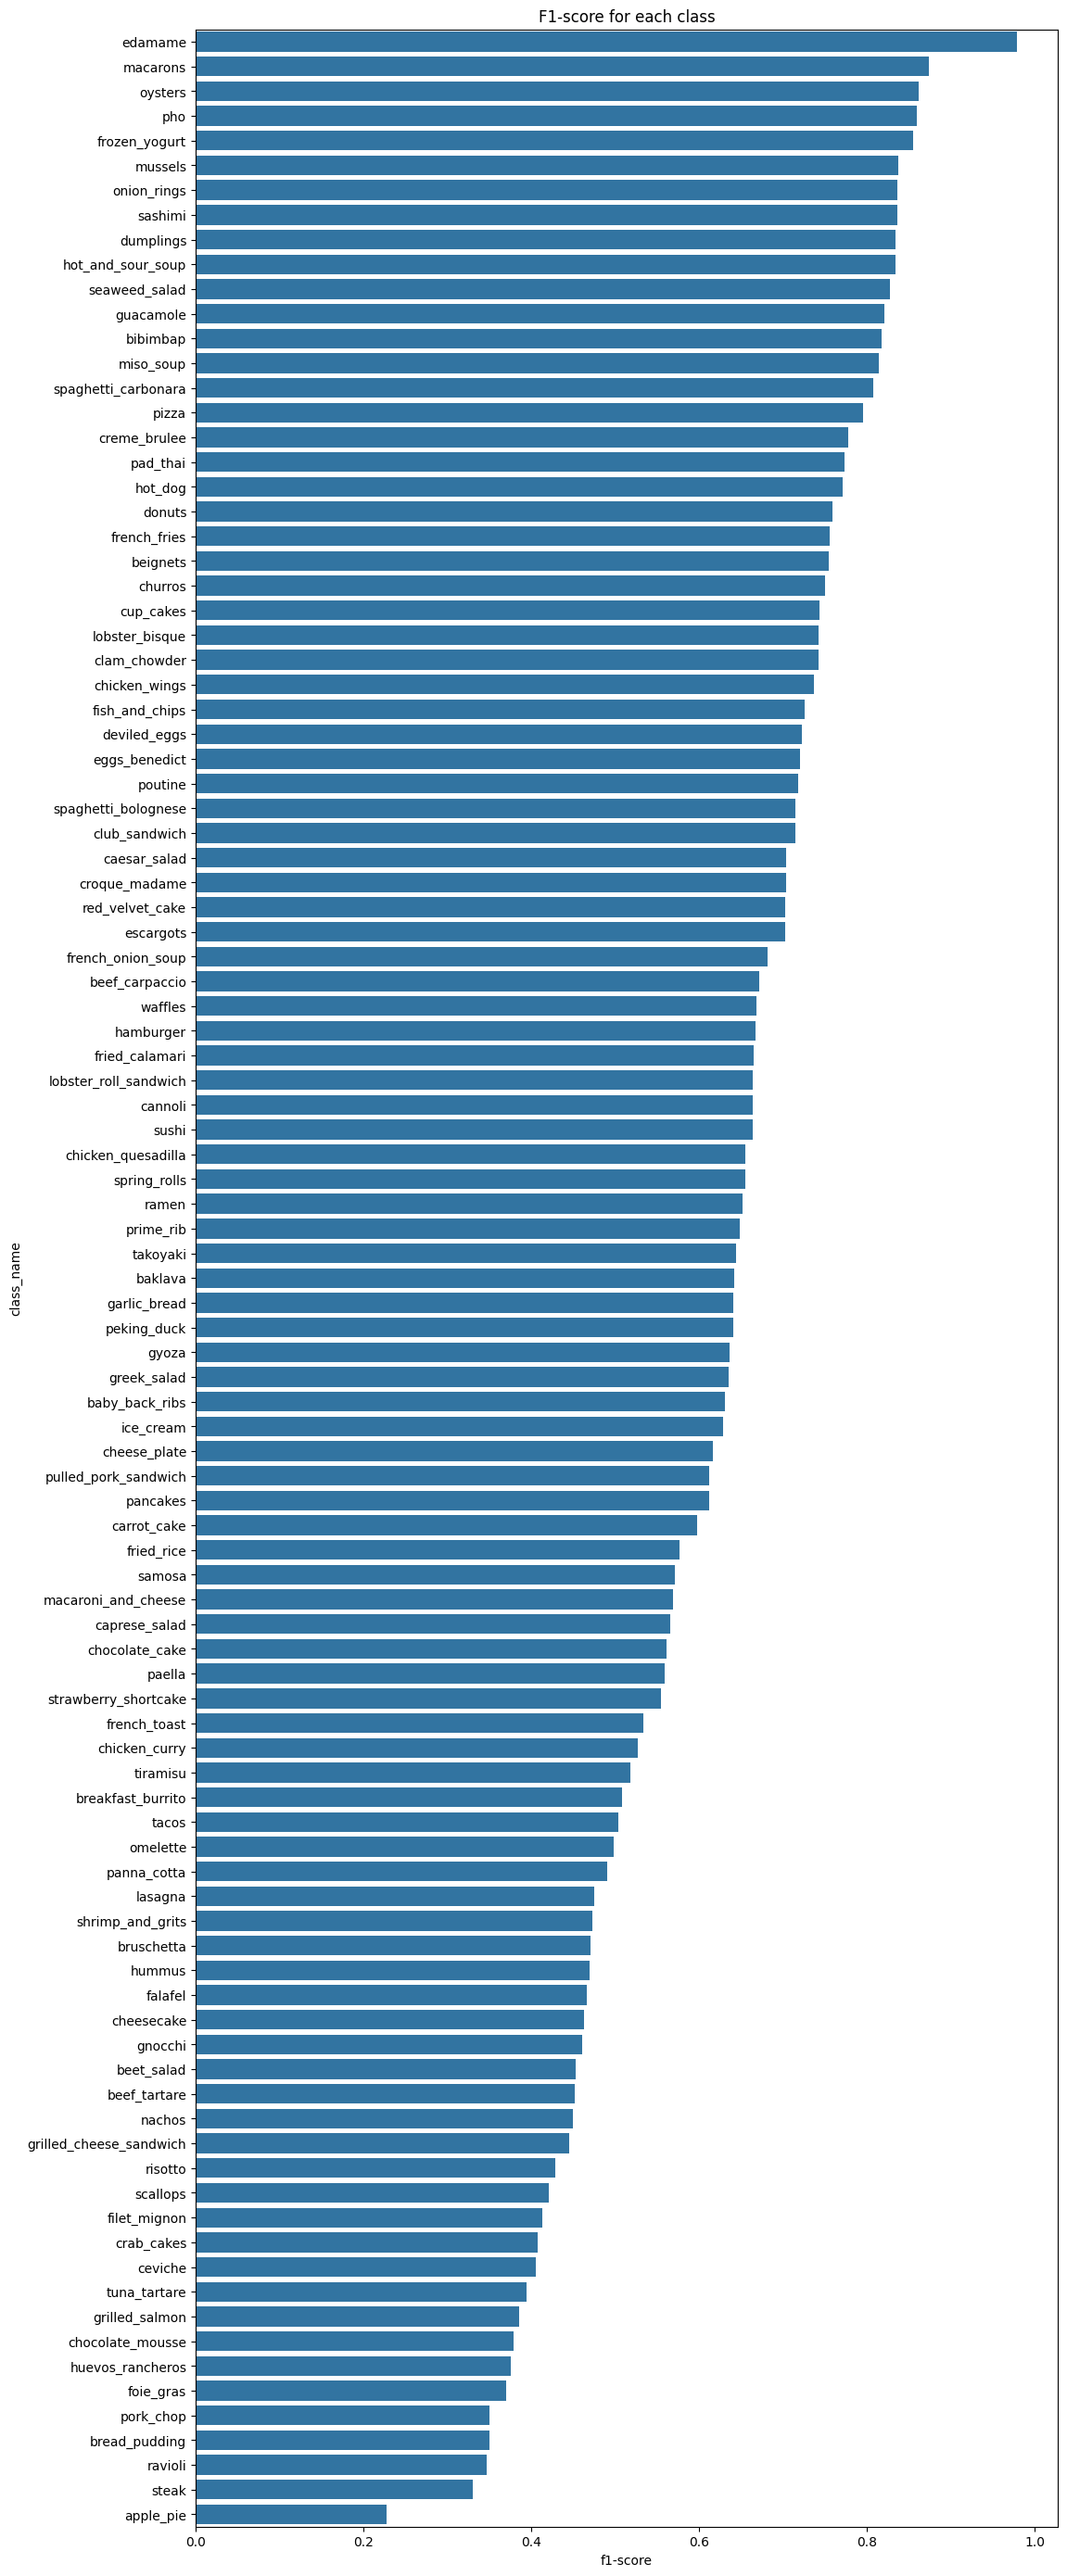

<Figure size 640x480 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 35))
sns.barplot(data=f1_scores, x="f1-score", y="class_name")
plt.title("F1-score for each class")
plt.figure()
plt.show()

In [62]:
# Create a function to load and prepare images.
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
    Reads in an image from filename, turns it into a tensor and reshapes into
    specified shape (img_shape, img_shape, color_channels=3).

    Args:
      filename (str): Path to target image
      image_shape (int): height/width dimension of target image shape
      scale (bool): scale pixel values from 0-225 to 0-1 or not.

    Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in a file name
  img = tf.io.read_file(filename)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  img = tf.image.decode_image(img, channels=3)
  # Resize the image.
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img   # don't need to rescale images for **EfficinetNet** models in tf

Now we've got a function to load and prepare target images,
Let's now write some code to visualize images, thier target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset.
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probabilities..

In [1]:
import os
import random


plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from random class.
  class_name = random.choice(test_data_all_10_percent.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions.
  img = load_and_prep_image(filepath)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = test_data_all_10_percent.class_names[pred_prob.argmax()]
  # print(pred_prob)
  # print(pred_class)

  # dispay the image.
  plt.subplot(1, 3, i+1)
  plt.imshow(img)
  if class_name == pred_class:
    title_color = "green"
  else:
    title_color = "red"
  plt.title(f"Actual: {class_name}\n Prediction: {pred_class} ")
  plt.axis(False);

NameError: name 'plt' is not defined

### Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction problabilities.
3. Use our DataFrame to find all the wrong predictions.